# Goals

### 1. Learn to implement Resnet V1 Bottleneck Block (Type - 1) using monk
    - Monk's Keras
    - Monk's Pytorch
    - Monk's Mxnet
    
### 2. Use network Monk's debugger to create complex blocks 


### 3. Understand how syntactically different it is to implement the same using
    - Traditional Keras
    - Traditional Pytorch
    - Traditional Mxnet

# Resnet V1 Bottleneck Block - Type 1
 
 - Note: The block structure can have variations too, this is just an example

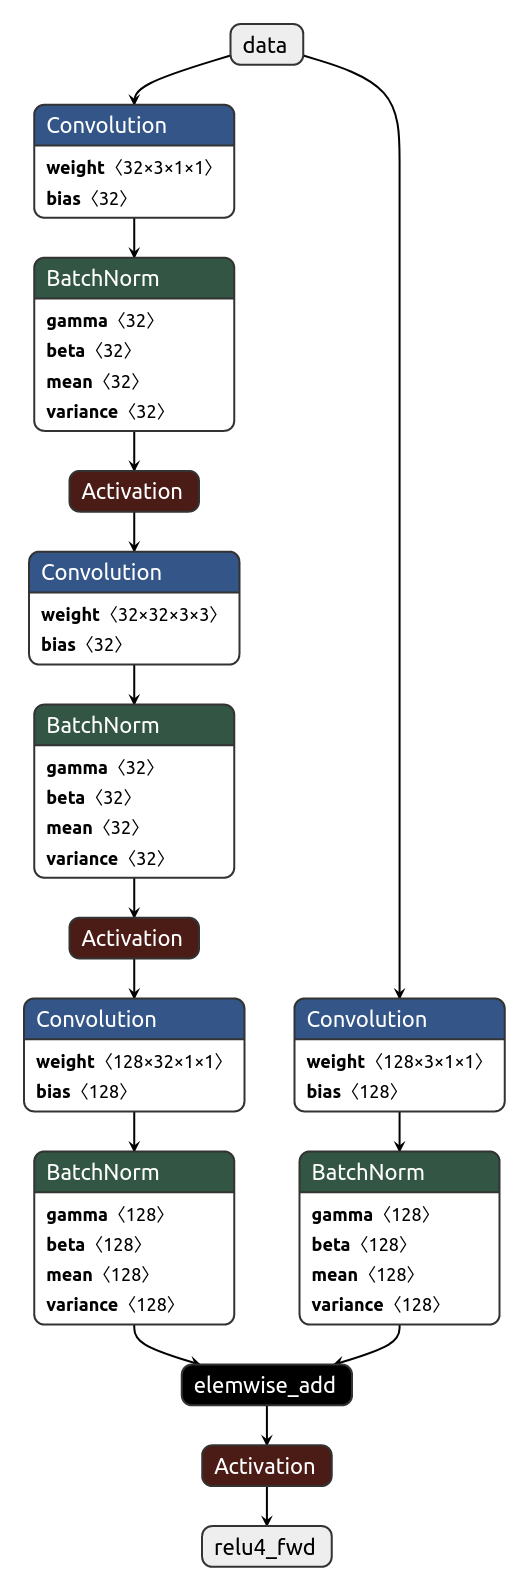

In [1]:
from IPython.display import Image
Image(filename='imgs/resnet_v1_bottleneck_with_downsample.png')

# Table of contents

[1. Install Monk](#1)


[2. Block basic Information](#2)

  - [2.1) Visual structure](#2-1)
  
  - [2.2) Layers in Branches](#2-2)


[3) Creating Block using monk visual debugger](#3)

  - [3.1) Create the first branch](#3-1)

  - [3.2) Create the second branch](#3-2)
  
  - [3.3) Merge the branches](#3-3)
  
  - [3.4) Debug the merged network](#3-4)
  
  - [3.5) Compile the network](#3-5)
  
  - [3.6) Visualize the network](#3-6)
  
  - [3.7) Run data through the network](#3-7)
  
  
[4) Creating Block Using MONK one line API call](#4)

  - [Mxnet Backend](#4-1)
  
  - [Pytorch Backend](#4-2)
  
  - [Keras Backend](#4-3)
  
  
  
[5) Appendix](#5)

  - [Study Material](#5-1)
  
  - [Creating block using traditional Mxnet](#5-2)
  
  - [Creating block using traditional Pytorch](#5-3)
  
  - [Creating block using traditional Keras](#5-4)
    

<a id='1'></a>
# Install Monk
  
 - git clone https://github.com/Tessellate-Imaging/monk_v1.git
 
 - cd monk_v1/installation && pip install -r requirements_cu9.txt
     - (Select the requirements file as per OS and CUDA version)

In [ ]:
!git clone https://github.com/Tessellate-Imaging/monk_v1.git

# Imports

In [2]:
# Common
import numpy as np
import math
import netron
from collections import OrderedDict
from functools import partial

In [3]:
# Monk
import os
import sys
sys.path.append("monk_v1/monk/");

<a id='2'></a>
# Block Information

<a id='2_1'></a>
## Visual structure

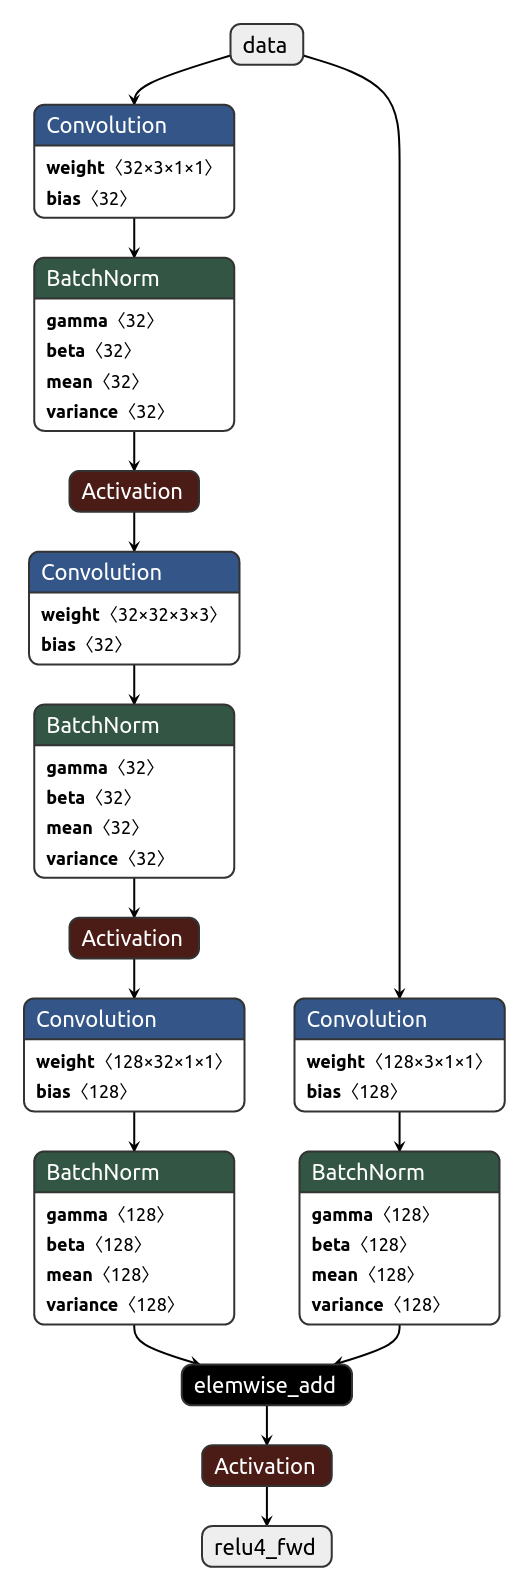

In [4]:
from IPython.display import Image
Image(filename='imgs/resnet_v1_bottleneck_with_downsample.png')

<a id='2_2'></a>
## Layers in Branches

  - Number of branches: 2
  
  
  - Branch 1
    - conv_1x1 -> batchnorm
  
  
  - Branch 2
    - conv_1x1 -> batchnorm -> relu -> conv_3x3 -> batchnorm -> relu -> conv1x1 -> batchnorm
    
    
  - Branches merged using
    - Elementwise addition
    
    
(See Appendix to read blogs on resnets)

<a id='3'></a>
# Creating Block using monk debugger

In [5]:
# Imports and setup a project
# To use pytorch backend - replace gluon_prototype with pytorch_prototype
# To use keras backend - replace gluon_prototype with keras_prototype

from gluon_prototype import prototype

# Create a sample project
gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");

Mxnet Version: 1.5.1

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/



<a id='3-1'></a>
## Create the first branch

In [6]:
def first_branch(output_channels=128, stride=1):
    network = [];
    network.append(gtf.convolution(output_channels=output_channels, kernel_size=1, stride=stride));
    network.append(gtf.batch_normalization());
    return network;

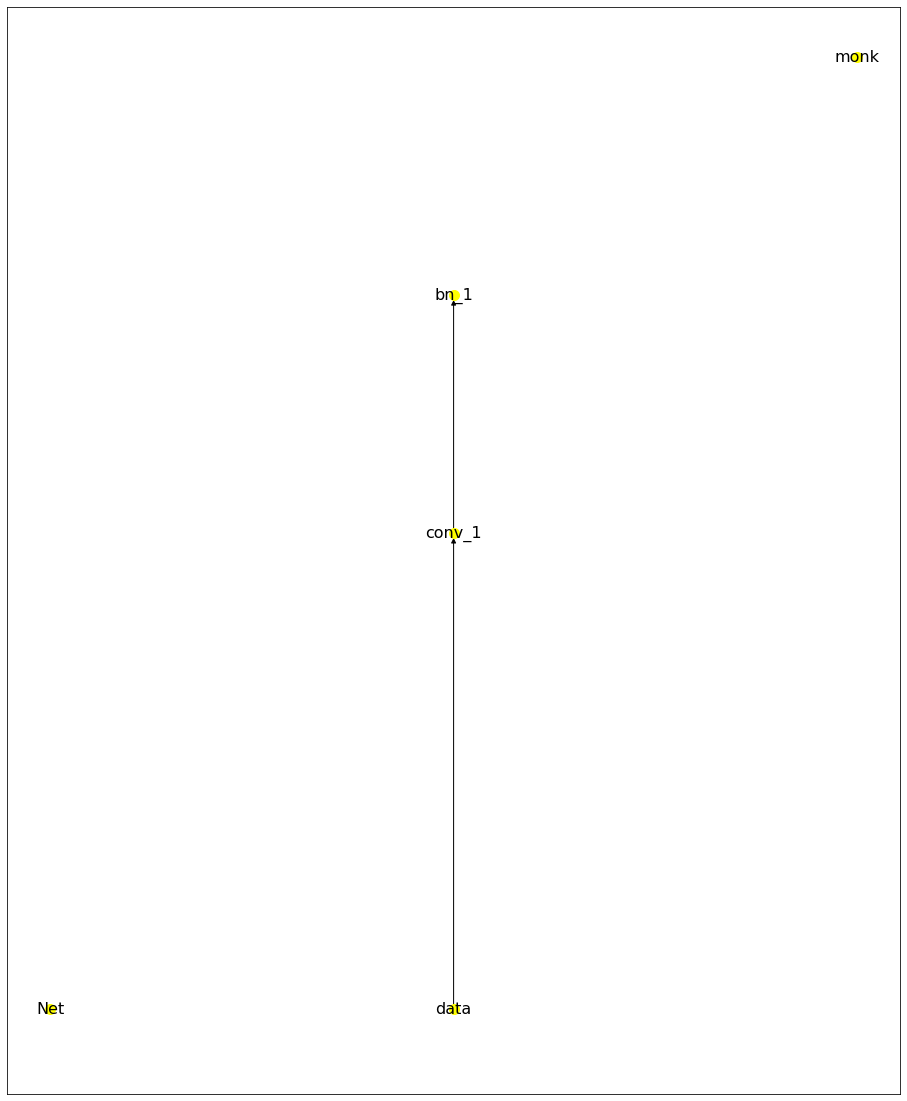

In [8]:
# Debug the branch
branch_1 = first_branch(output_channels=128, stride=1)
network = [];
network.append(branch_1);
gtf.debug_custom_model_design(network);

<a id='3-2'></a>
## Create the second branch

In [9]:
def second_branch(output_channels=128, stride=1):
    network = [];
    
    # Bottleneck convolution 
    network.append(gtf.convolution(output_channels=output_channels//4, kernel_size=1, stride=stride));
    network.append(gtf.batch_normalization());
    network.append(gtf.relu());
    
    #Bottleneck convolution
    network.append(gtf.convolution(output_channels=output_channels//4, kernel_size=1, stride=stride));
    network.append(gtf.batch_normalization());
    network.append(gtf.relu());
    
    #Normal convolution
    network.append(gtf.convolution(output_channels=output_channels, kernel_size=1, stride=1));
    network.append(gtf.batch_normalization());
    return network;

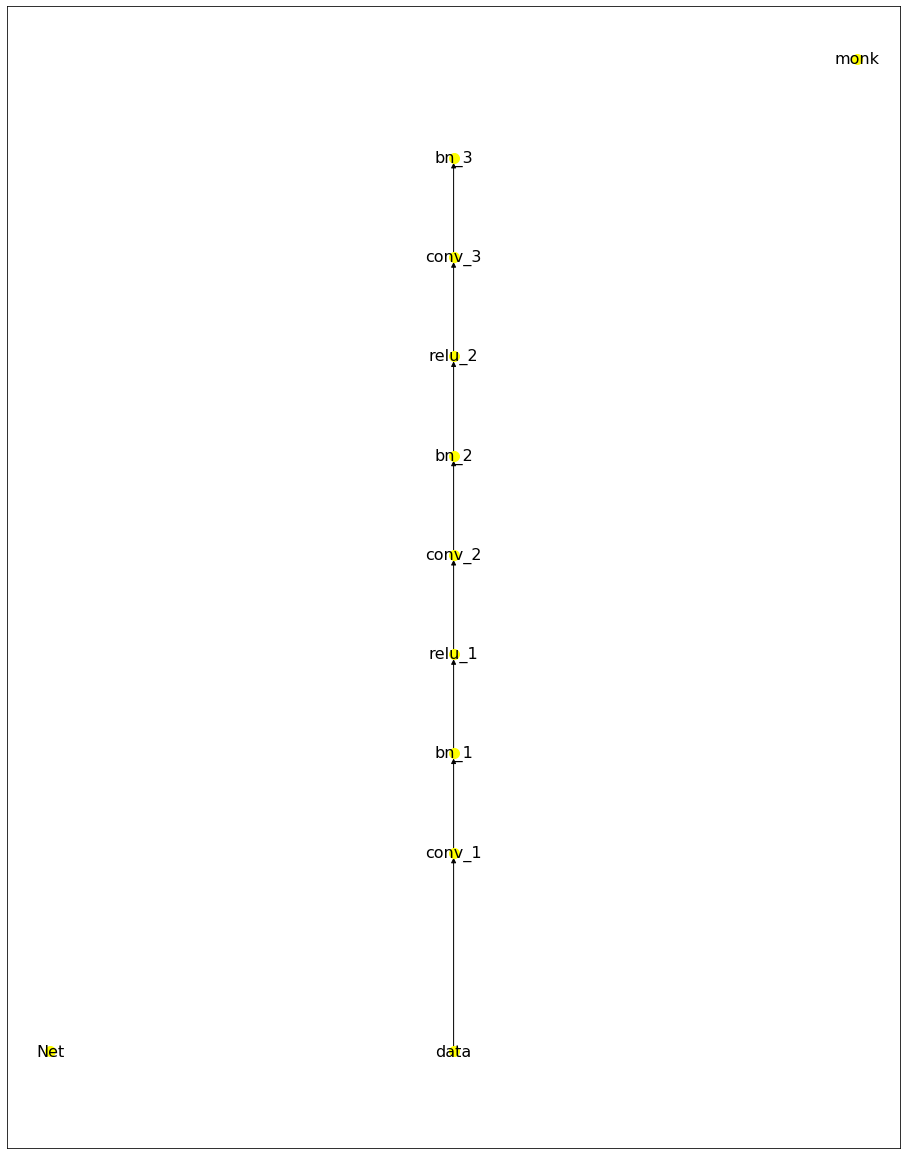

In [10]:
# Debug the branch
branch_2 = second_branch(output_channels=128, stride=1)
network = [];
network.append(branch_2);
gtf.debug_custom_model_design(network);

<a id='3-3'></a>
## Merge the branches

In [11]:
def final_block(output_channels=128, stride=1):
    network = [];
    
    #Create subnetwork and add branches
    subnetwork = [];
    branch_1 = first_branch(output_channels=output_channels, stride=stride)
    branch_2 = second_branch(output_channels=output_channels, stride=stride)
    subnetwork.append(branch_1);
    subnetwork.append(branch_2);
    
    # Add merging element
    subnetwork.append(gtf.add());
    
    # Add the subnetwork
    network.append(subnetwork)
    network.append(gtf.relu());
    return network;

<a id='3-4'></a>
## Debug the merged network

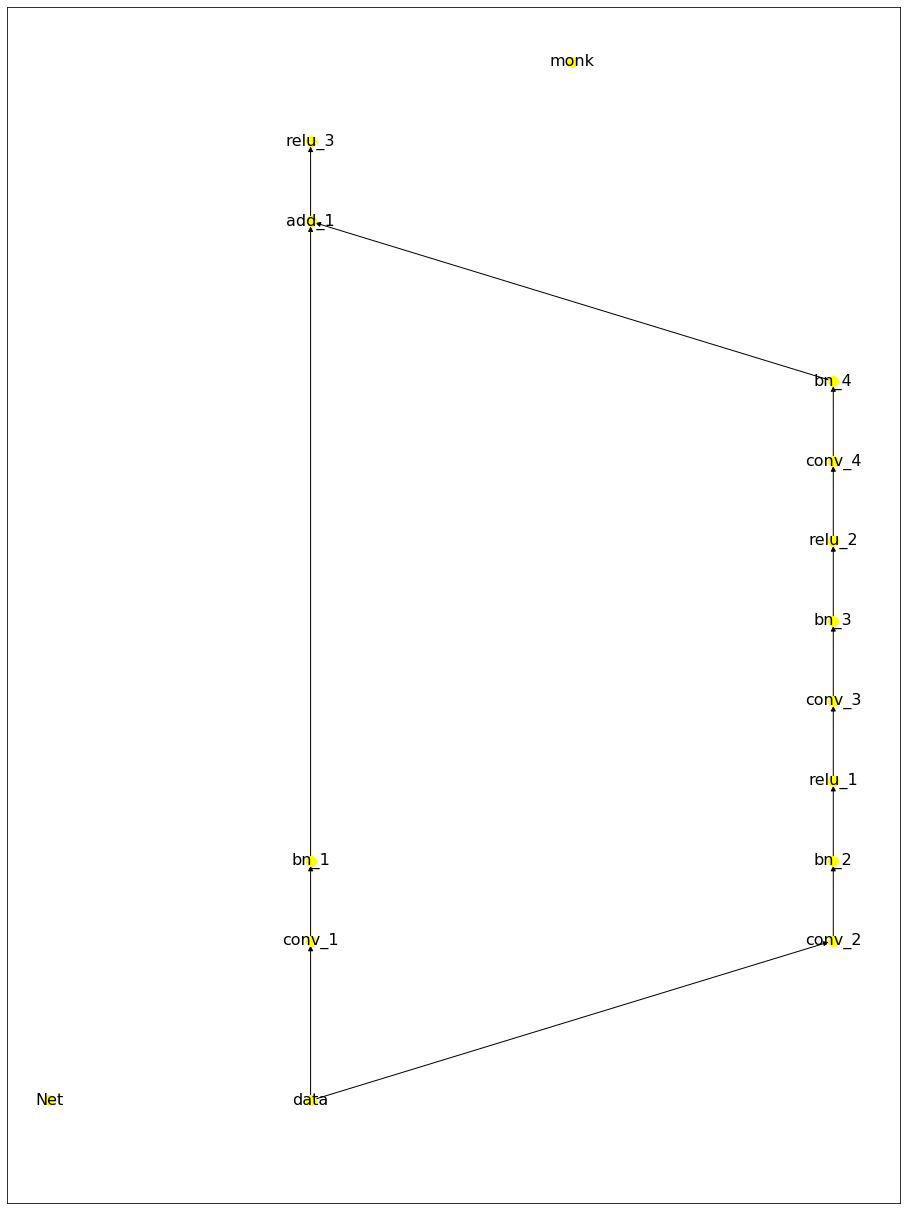

In [12]:
final = final_block(output_channels=128, stride=1)
network = [];
network.append(final);
gtf.debug_custom_model_design(network);

<a id='3-5'></a>
## Compile the network

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num of potentially trainable layers:  8
        Num of actual trainable layers:       8



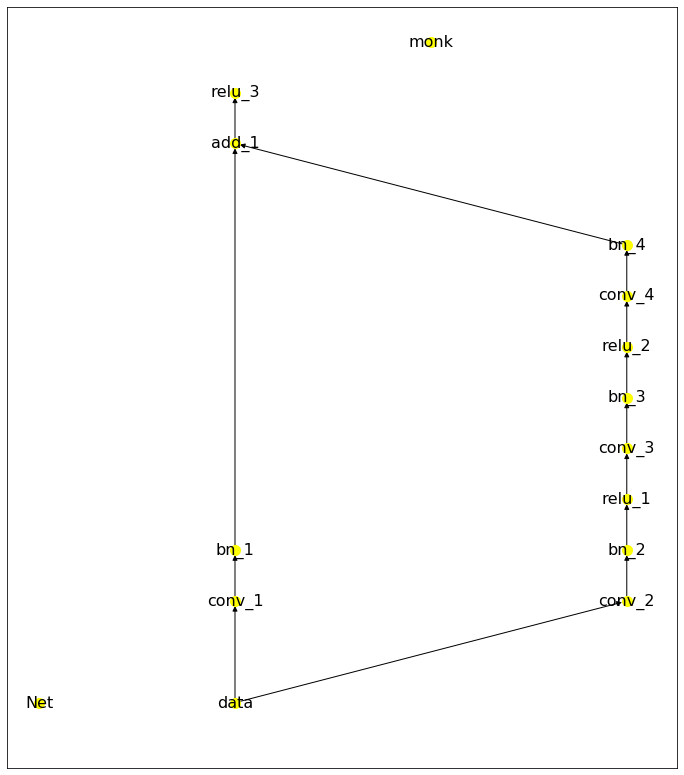

In [13]:
gtf.Compile_Network(network, data_shape=(3, 224, 224), use_gpu=False);

<a id='3-6'></a>
## Run data through the network

In [14]:
import mxnet as mx
x = np.zeros((1, 3, 224, 224));
x = mx.nd.array(x);
y = gtf.system_dict["local"]["model"].forward(x);
print(x.shape, y.shape)

(1, 3, 224, 224) (1, 128, 224, 224)


<a id='3-7'></a>
## Visualize network using netron

In [15]:
gtf.Visualize_With_Netron(data_shape=(3, 224, 224))

Using Netron To Visualize
Not compatible on kaggle
Compatible only for Jupyter Notebooks
Serving 'model-symbol.json' at http://localhost:8080


<a id='4'></a>
# Creating Using MONK LOW code API

<a id='4-1'></a>
## Mxnet backend

Mxnet Version: 1.5.1

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num of potentially trainable layers:  8
        Num of actual trainable layers:       8



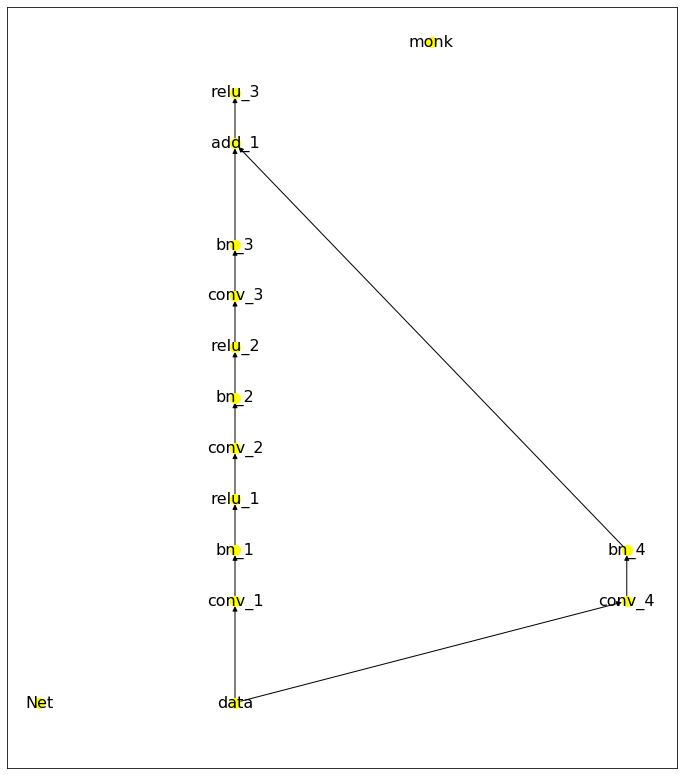

In [16]:
from gluon_prototype import prototype
gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.resnet_v1_bottleneck_block(output_channels=128, downsample=True));


gtf.Compile_Network(network, data_shape=(3, 224, 224), use_gpu=False);


<a id='4-2'></a>
## Pytorch backend

  - Only the import changes

Pytorch Version: 1.2.0

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num layers in model:  8
        Num trainable layers: 8



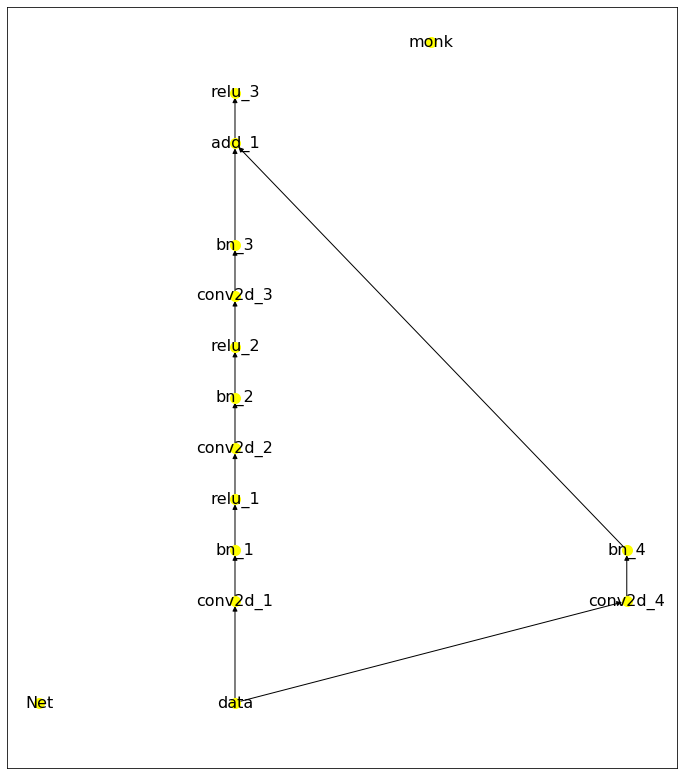

In [17]:
#Change gluon_prototype to pytorch_prototype
from pytorch_prototype import prototype


gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.resnet_v1_bottleneck_block(output_channels=64, downsample=True));


gtf.Compile_Network(network, data_shape=(3, 224, 224), use_gpu=False);

<a id='4-3'></a>
## Keras backend

  - Only the import changes

Keras Version: 2.2.5
Tensorflow Version: 1.12.0

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num layers in model:  13
        Num trainable layers: 12



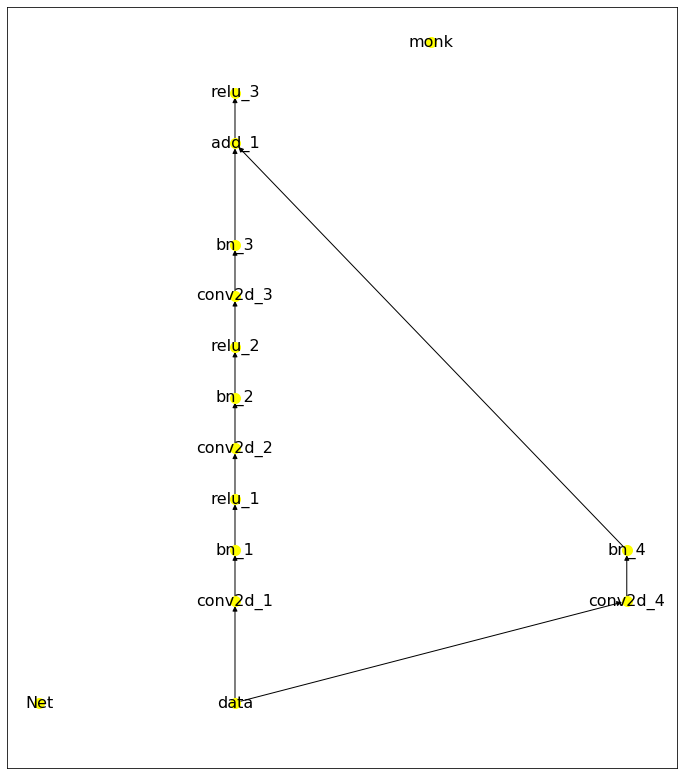

In [19]:
#Change gluon_prototype to keras_prototype
from keras_prototype import prototype


gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.resnet_v1_bottleneck_block(output_channels=64, downsample=True));


gtf.Compile_Network(network, data_shape=(3, 224, 224), use_gpu=False);

<a id='5'></a>
# Appendix

<a id='5-1'></a>
## Study links
  - https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
  - https://medium.com/@MaheshNKhatri/resnet-block-explanation-with-a-terminology-deep-dive-989e15e3d691
  - https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c
  - https://hackernoon.com/resnet-block-level-design-with-deep-learning-studio-part-1-727c6f4927ac

<a id='5-2'></a>
## Creating block using traditional Mxnet

 - Code credits - https://mxnet.incubator.apache.org/

In [20]:
# Traditional-Mxnet-gluon
import mxnet as mx
from mxnet.gluon import nn
from mxnet.gluon.nn import HybridBlock, BatchNorm
from mxnet.gluon.contrib.nn import HybridConcurrent, Identity
from mxnet import gluon, init, nd

In [21]:

def _conv3x3(channels, stride, in_channels):
    return nn.Conv2D(channels, kernel_size=3, strides=stride, padding=1,
                     use_bias=False, in_channels=in_channels)

class ResnetBlockV1(HybridBlock):
    def __init__(self, channels, stride, in_channels=0, **kwargs):
        super(ResnetBlockV1, self).__init__(**kwargs)
        
        #Branch - 1
        self.branch = nn.HybridSequential(prefix='')
        self.branch.add(nn.Conv2D(channels, kernel_size=1, strides=stride,
                                          use_bias=False, in_channels=in_channels))
        self.branch.add(nn.BatchNorm())
        
        
        # Branch - 2
        self.body = nn.HybridSequential(prefix='')
        self.body.add(nn.Conv2D(channels//4, kernel_size=1, strides=stride,
                                          use_bias=False, in_channels=in_channels))
        self.body.add(nn.BatchNorm())
        self.body.add(nn.Activation('relu'))
        self.body.add(_conv3x3(channels//4, stride, in_channels))
        self.body.add(nn.BatchNorm())
        self.body.add(nn.Activation('relu'))
        self.body.add(nn.Conv2D(channels, kernel_size=1, strides=stride,
                                          use_bias=False, in_channels=in_channels))
        self.body.add(nn.BatchNorm())
        

    def hybrid_forward(self, F, x):
        residual = self.branch(x)
        x = self.body(x)
        x = F.Activation(residual+x, act_type='relu')
        return x

In [22]:
# Invoke the block
block = ResnetBlockV1(64, 1)

# Initialize network and load block on machine
ctx = [mx.cpu()];
block.initialize(init.Xavier(), ctx = ctx);
block.collect_params().reset_ctx(ctx)
block.hybridize()

# Run data through network
x = np.zeros((1, 3, 224, 224));
x = mx.nd.array(x);
y = block.forward(x);
print(x.shape, y.shape)


# Export Model to Load on Netron
block.export("final", epoch=0);

netron.start("final-symbol.json", port=8082)

(1, 3, 224, 224) (1, 64, 224, 224)
Serving 'final-symbol.json' at http://localhost:8082


<a id='5-3'></a>
## Creating block using traditional Pytorch

 - Code credits - https://pytorch.org/

In [23]:
# Traiditional-Pytorch
import torch
from torch import nn
from torch.jit.annotations import List
import torch.nn.functional as F

In [24]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class ResnetBottleNeckBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(ResnetBottleNeckBlock, self).__init__()
        
        norm_layer = nn.BatchNorm2d
        
        # Branch - 1
        self.conv0 = conv1x1(inplanes, planes, stride)
        self.bn0 = norm_layer(planes)
        
        
        # Branch - 2
        self.conv1 = conv1x1(inplanes, planes//4, stride)
        self.bn1 = norm_layer(planes//4)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes//4, planes//4, stride)
        self.bn2 = norm_layer(planes//4)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = conv1x1(planes//4, planes)
        self.bn3 = norm_layer(planes)
        
        self.stride = stride

        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = self.conv0(x)
        identity = self.bn0(identity)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out

In [25]:
# Invoke the block
block = ResnetBottleNeckBlock(3, 64, stride=1);

# Initialize network and load block on machine
layers = []
layers.append(block);
net = nn.Sequential(*layers);

# Run data through network
x = torch.randn(1, 3, 224, 224)
y = net(x)
print(x.shape, y.shape);

# Export Model to Load on Netron
torch.onnx.export(net,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})
netron.start('model.onnx', port=9998);


torch.Size([1, 3, 224, 224]) torch.Size([1, 64, 224, 224])
Serving 'model.onnx' at http://localhost:9998


<a id='5-4'></a>
## Creating block using traditional Keras

 - Code credits: https://keras.io/

In [26]:
# Traditional-Keras
import keras
import keras.layers as kla
import keras.models as kmo
import tensorflow as tf
from keras.models import Model
backend = 'channels_last'
from keras import layers

In [27]:
def resnet_conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(1, 1)):

    filters1, filters2, filters3 = filters
    bn_axis = 3
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    
    # Branch - 1
    #Identity
    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '1a')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1a')(shortcut)
    
    
    # Branch - 2
    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters2, (3, 3), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b', padding="same")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def create_model(input_shape, kernel_size, filters, stage, block):
    img_input = layers.Input(shape=input_shape);
    x = resnet_conv_block(img_input, kernel_size, filters, stage, block)    
    return Model(img_input, x);

In [28]:
# Invoke the block
kernel_size=3;
filters=[16, 16, 64];
input_shape=(224, 224, 3);
model = create_model(input_shape, kernel_size, filters, 0, "0");

# Run data through network
x = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
y = model(x)
print(x.shape, y.shape)

# Export Model to Load on Netron
model.save("final.h5");
netron.start("final.h5", port=8082)

(1, 224, 224, 3) (1, 224, 224, 64)

Stopping http://localhost:8082
Serving 'final.h5' at http://localhost:8082
